In [1]:
#Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import datetime as dt
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import time
from datetime import date, timedelta
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from scipy.stats import poisson
import scipy.stats as stats
%matplotlib inline

from google.oauth2.service_account import Credentials
import google_auth_httplib2
import pygsheets
import df2gspread as d2g
import googleapiclient
from googleapiclient  import discovery
from httplib2 import Http
from oauth2client import file, client, tools
from gspread_formatting.dataframe import format_with_dataframe, BasicFormatter
from gspread_formatting import Color
import logging

from oauth2client.service_account import ServiceAccountCredentials
from google.oauth2 import service_account
import gslides
from gslides import (Frame,Presentation,Spreadsheet,Table,Series,Chart)

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

import sqlalchemy as db
from sqlalchemy import create_engine
import mysql.connector
import psycopg2
from prophet import Prophet

In [2]:
data = pd.read_csv('C:/Users/leemn/Downloads/Prophet Model - Time series/train_df.csv')

In [3]:
data.head()

,date,store,item,sales
0,2013-01-01,2,28,45
1,2013-01-02,2,28,53
2,2013-01-03,2,28,65
3,2013-01-04,2,28,66
4,2013-01-05,2,28,97


In [4]:
data.shape

(1826, 4)

In [7]:
data['store'].nunique()

1

In [8]:
data['item'].nunique()

1

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1826 entries, 0 to 1825
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    1826 non-null   object
 1   store   1826 non-null   int64 
 2   item    1826 non-null   int64 
 3   sales   1826 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 57.2+ KB


In [6]:
data['date'] = pd.to_datetime(data['date'])

In [9]:
print("The data has sales from {} to {}".format(min(data['date']),
                                                 max(data['date'])))

The data has sales from 2013-01-01 00:00:00 to 2017-12-31 00:00:00


In [10]:
data.drop(['store','item'], axis=1, inplace=True)

In [11]:
# need to rename the date column to ds and transactions columns to y.
data.columns = ['ds', 'y']
data.head()

,ds,y
0,2013-01-01,45
1,2013-01-02,53
2,2013-01-03,65
3,2013-01-04,66
4,2013-01-05,97


In [13]:
df_store_2_item_28_time = data.set_index('ds')
df_store_2_item_28_time.head()

,y
ds,
2013-01-01,45
2013-01-02,53
2013-01-03,65
2013-01-04,66
2013-01-05,97


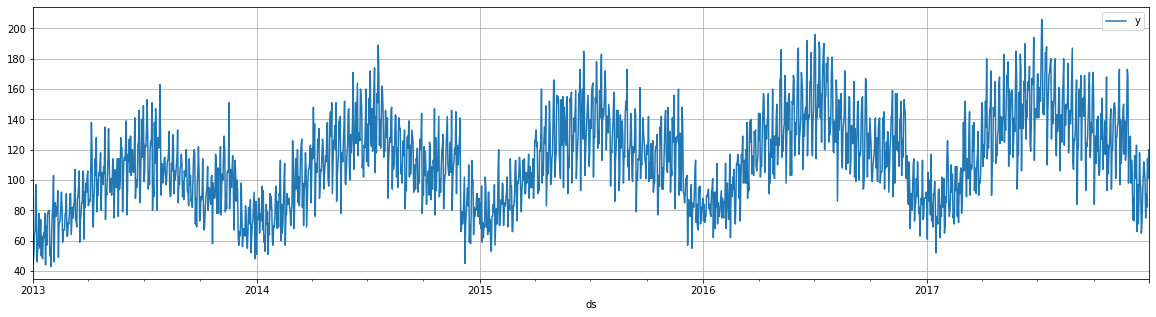

In [14]:
# Plot the entire time series and show gridlines
df_store_2_item_28_time.plot(grid=True,figsize=(20,5))
plt.show()

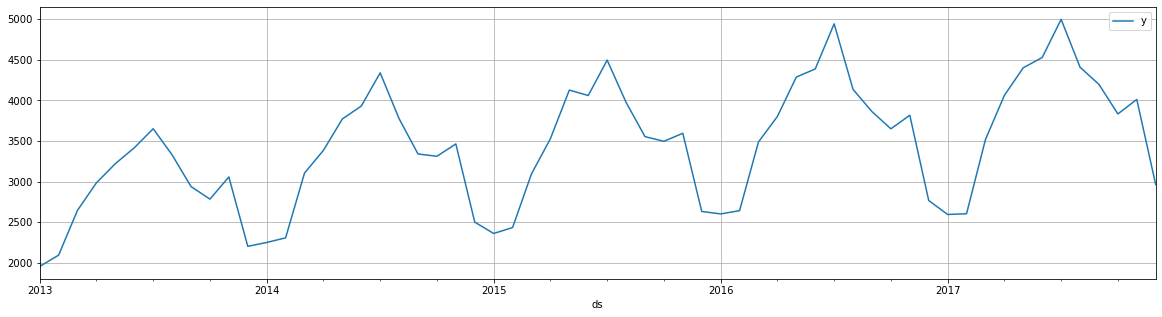

In [15]:
# Plot the entire time series and show gridlines
df_store_2_item_28_time.resample('M').sum().plot(grid=True,figsize=(20,5))
plt.show()

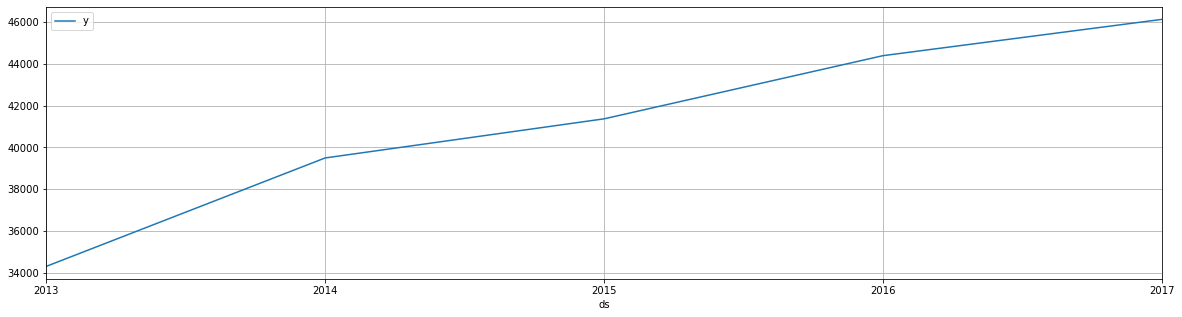

In [16]:
df_store_2_item_28_time.resample('A').sum().plot(grid=True,figsize=(20,5))
plt.show()

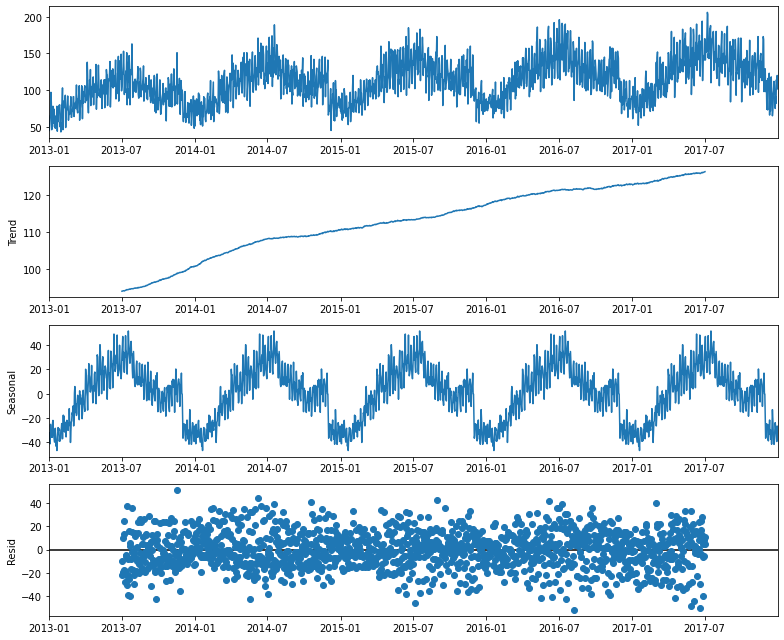

In [19]:
from pylab import rcParams
rcParams['figure.figsize'] = 11, 9
decomposition = sm.tsa.seasonal_decompose(df_store_2_item_28_time, 
                                         model = 'additive',
                                         period=365) 
fig = decomposition.plot()
plt.show()

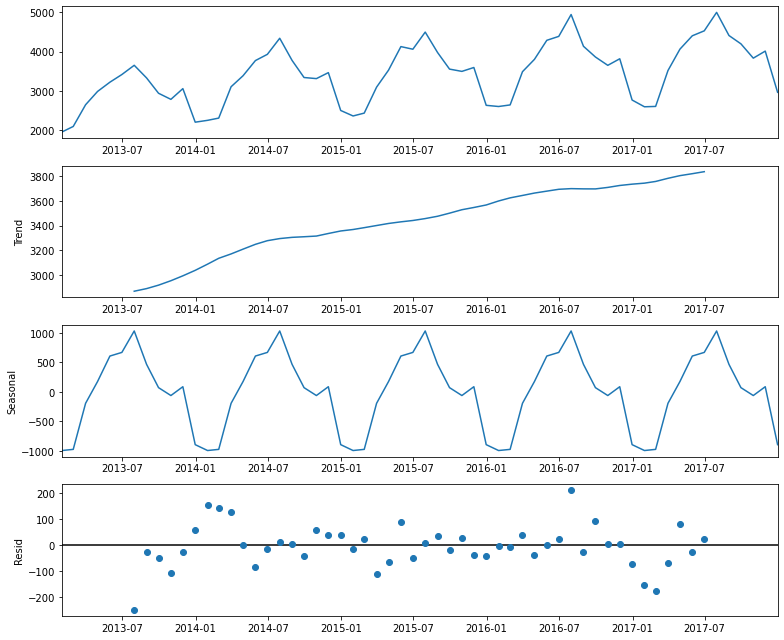

In [20]:
decomposition = sm.tsa.seasonal_decompose(df_store_2_item_28_time.resample('M').sum(), 
                                          model = 'additive',
                                         period=12) 
fig = decomposition.plot()
plt.show()

From the decomposition above we can conclude:

- There is a upward trend on sales, i.e., our time series is not stationary.
- From the seasonal component we can observe that the model is additive, since the seasonal component is similar (not getting multiplied) over the period of time.
- Also we can observe on the seasonal component seasonality in sales with lower sales in January and higher sales in July.

##  Forecasting with Facebook Prophet

### Train Model
To train a model in Prophet, first we create an instance of the model class and then we call the fit method.

In principle, you don't need to specify any hyparameters. One important exception is seasonality_mode. It is important to set this parameter to multiplicative if your model is multiplicative since Prophet is based on an additive model. As we saw previously, the seasonality in our model follows an additive behavior. Therefore, there is no need to set seasonality_mode as multiplicative.

Although Prophet is able to find automatically a good set of hyperparameters, we will see later that some fine tuning can improve performance. Specially, applying your knowledge of the business case might make a huge difference even if Prophet has the power of handling many things by itself.

Just to exemplify, I'll include the parameter interval_width that sets the confidence interval.

In [23]:
m = Prophet(interval_width=0.95)   # by default is 80%
model = m.fit(data)

2022-07-16 23:49:53,874 : DEBUG : cmd: where.exe tbb.dll
cwd: None
2022-07-16 23:49:53,949 : DEBUG : TBB already found in load path
2022-07-16 23:49:53,956 : INFO : Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2022-07-16 23:49:53,976 : DEBUG : input tempfile: C:\Users\leemn\AppData\Local\Temp\tmpxceg3kki\vndtjaiz.json
2022-07-16 23:49:54,011 : DEBUG : input tempfile: C:\Users\leemn\AppData\Local\Temp\tmpxceg3kki\qew1tir_.json
2022-07-16 23:49:54,013 : DEBUG : idx 0
2022-07-16 23:49:54,014 : DEBUG : running CmdStan, num_threads: None
2022-07-16 23:49:54,014 : DEBUG : CmdStan args: ['C:\\Users\\leemn\\AppData\\Roaming\\Python\\Python39\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=15875', 'data', 'file=C:\\Users\\leemn\\AppData\\Local\\Temp\\tmpxceg3kki\\vndtjaiz.json', 'init=C:\\Users\\leemn\\AppData\\Local\\Temp\\tmpxceg3kki\\qew1tir_.json', 'output', 'file=C:\\Users\\leemn\\AppData\\Local\\Temp\\tmpiabq5mnw\\prophet_

## Forecast
In order to forecast we first need to create a dataframe that will save our predictions. Method make_future_dataframe builds a dataframe that extends into the future a specified number of days. In our case, we will predict 90 days into the future.

By default the dataframe created includes the dates from the history, so we see the model fit as well.

In [24]:
future = m.make_future_dataframe(periods=90) 
future.head()

,ds
0,2013-01-01
1,2013-01-02
2,2013-01-03
3,2013-01-04
4,2013-01-05


In [25]:
# make predictions
forecast = m.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-01-01,93.094490,31.200684,75.161845,93.094490,93.094490,-41.023968,-41.023968,-41.023968,-9.027356,-9.027356,-9.027356,-31.996611,-31.996611,-31.996611,0.0,0.0,0.0,52.070522
1,2013-01-02,93.091660,31.005787,77.190923,93.091660,93.091660,-40.309938,-40.309938,-40.309938,-8.342759,-8.342759,-8.342759,-31.967179,-31.967179,-31.967179,0.0,0.0,0.0,52.781723
2,2013-01-03,93.088830,37.780972,83.771209,93.088830,93.088830,-32.802285,-32.802285,-32.802285,-0.822987,-0.822987,-0.822987,-31.979298,-31.979298,-31.979298,0.0,0.0,0.0,60.286545
3,2013-01-04,93.086001,44.807268,90.353587,93.086001,93.086001,-25.211335,-25.211335,-25.211335,6.819334,6.819334,6.819334,-32.030669,-32.030669,-32.030669,0.0,0.0,0.0,67.874666
4,2013-01-05,93.083171,51.369609,96.695949,93.083171,93.083171,-18.307377,-18.307377,-18.307377,13.810384,13.810384,13.810384,-32.117761,-32.117761,-32.117761,0.0,0.0,0.0,74.775794


The forecast dataframe contains Prophet’s prediction for sales. Because we've also passed historical dates, it provides an in-sample fit that we can use to evaluate our model.

Forecast includes a column yhat with the forecast, as well as columns for components and uncertainty intervals.

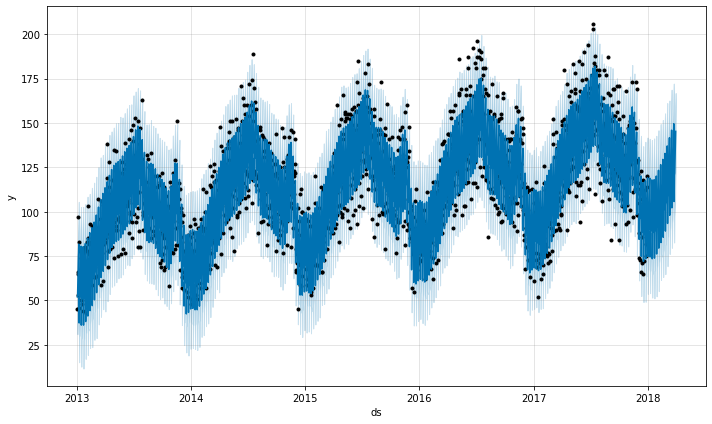

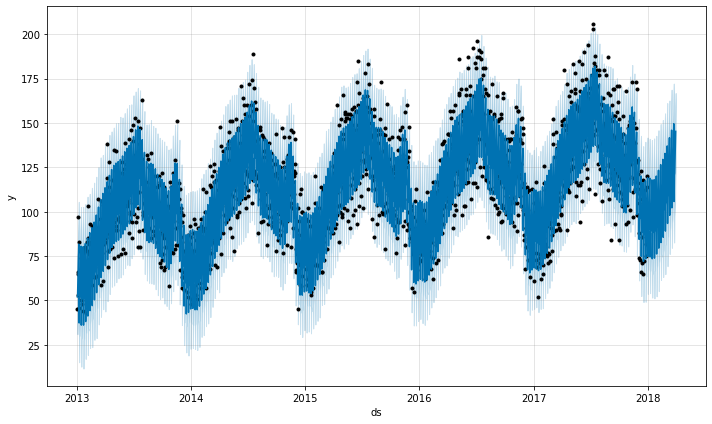

In [26]:
m.plot(forecast)

In the forecast plot above, 
- deep blue line is forecast sales forecast['y_hat'], 
- black dots are actual sales forecast['y']. 
- The light blue shade is 95% confidence interval around the forecast. 
- The uncertainty interval in this region is bounded by forecast['yhat_lower'] and forecast['yhat_upper'] values.

## Trend Changepoints
Real life time series such as this one, frequently have abrupt changes in their trajectories. These changepoints sign abrupt changes in the time series caused, for instances, by new product launch, unforeseen calamity. Prophet will automatically detect these changepoints and will allow the trend to adapt appropriately. At these points, the growth rate is allowed to change making the model more flexible. This may cause overfitting or underfitting.

A parameter called changepoint_prior_scale could be used to adjust the trend flexibility and tackle overfitting and underfitting. Higher value fits a more flexible curve to the time series.

By default changepoints are only inferred for the first 80% of the time series, but you can change it by making use of the changepoint_range argument of the model.

It is also possible to add your own changepoints manually, using the changepoints argument.

In the plot below, the dotted lines represent the changepoints for the given time series.

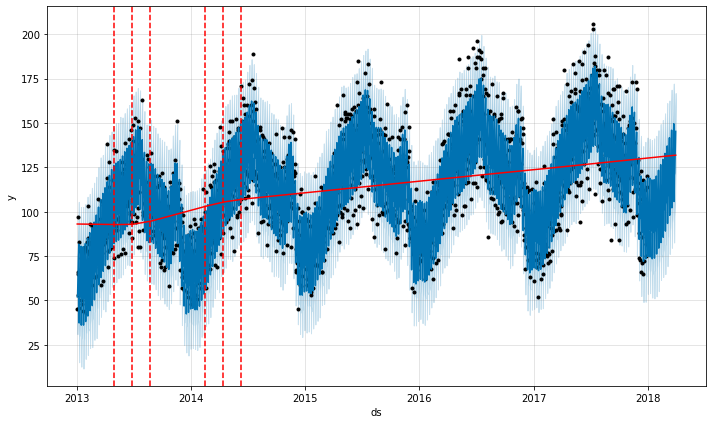

In [29]:
from prophet.plot import add_changepoints_to_plot

plot1 = m.plot(forecast)
add_changepoints_to_plot(plot1.gca(),m,forecast);

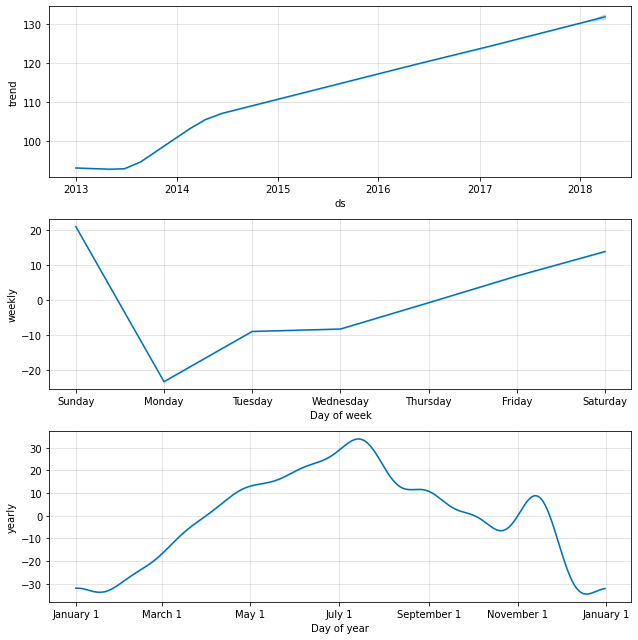

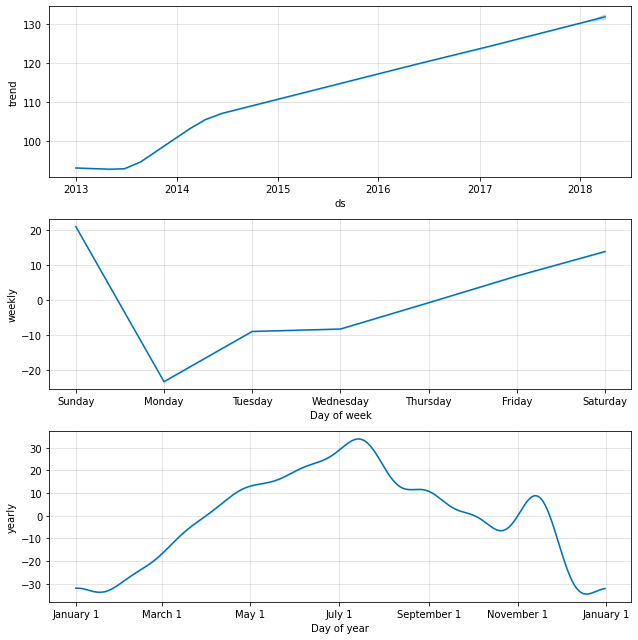

In [30]:
m.plot_components(forecast)

We can observe the following on forecast components plotted above:

- Trend component:
   The trend upwards.
-Weekly seasonality component:
   The weekly seasonality shows that people buy more on weekends. In particular, we observe a drop on sales from Sunday to Monday. This might point to a holiday effect.
- Yearly seasonality component:
   As observe previously the volume of sales is higher in July and lower in January. This peak in sales in July might mean seasonal sales with high discount prices.
   
Holidays, special events, as well as seasonality can be explored to improve your model. For more information on how to use this information check Prophet's documentation section Seasonality, Holiday Effects, And Regressors.

## Evaluate model

The forecast dataframe includes predictions made on the training data dates. Therefore, we can use this in-sample fit to evaluate our model.

In [32]:
df_merge = pd.merge(data, forecast[['ds','yhat_lower','yhat_upper','yhat']],on='ds')
df_merge = df_merge[['ds','yhat_lower','yhat_upper','yhat','y']]
df_merge.head()

,ds,yhat_lower,yhat_upper,yhat,y
0,2013-01-01,31.200684,75.161845,52.070522,45
1,2013-01-02,31.005787,77.190923,52.781723,53
2,2013-01-03,37.780972,83.771209,60.286545,65
3,2013-01-04,44.807268,90.353587,67.874666,66
4,2013-01-05,51.369609,96.695949,74.775794,97


In [33]:
# calculate MAE between observed and predicted values 
y_true = df_merge['y'].values
y_pred = df_merge['yhat'].values
mae_01 = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae_01)

MAE: 9.280


In [34]:
mape_01 = mean_absolute_percentage_error(y_true, y_pred)
print('MAPE: %.3f' % mape_01)

MAPE: 0.087


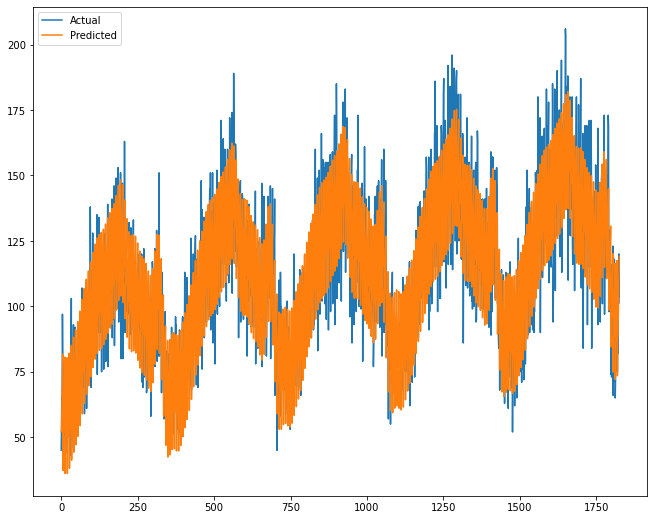

In [35]:
# plot expected vs actual
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

### Saving and Loading the Best model

 In Python, Prophet models should not be saved with pickle; the Stan backend attached to the model object will not pickle well, and will produce issues under certain versions of Python. Instead, you should use the built-in serialization functions to serialize the model to json.

In [37]:
import json
from prophet.serialize import model_to_json, model_from_json

### Save model

In [38]:
with open('prophet_model.json', 'w') as fout:
    json.dump(model_to_json(m), fout)  

### Load model

In [39]:
with open('prophet_model.json', 'r') as fin:
    m = model_from_json(json.load(fin)) 

2022-07-17 00:41:45,457 : DEBUG : cmd: where.exe tbb.dll
cwd: None
2022-07-17 00:41:45,562 : DEBUG : TBB already found in load path
